In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import re as re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
import xgboost as xgb

In [2]:
def preprocess(file):
    df = pd.read_csv(file, header=0, dtype={'Age': np.float64})

    mean_Age = df['Age'].mean()
    std_Age = df['Age'].std()
    labelencoder = LabelEncoder()
    df['Sex'] = labelencoder.fit_transform(df['Sex'])
    
    # print(labelencoder.inverse_transform([0,1]))
    # le_name_mapping = list(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
    # print(le_name_mapping)
    def isAlone(row):
        if row['FamilySize'] == 1:
            return 1
        else:
            return 0

    def hasCabin(row):
        #     np.isnan doesn't work for Objects data type
        if pd.isnull(row['Cabin']):
            return 0
        else:
            return 1

    def ageFill(row):
        if (pd.isnull(row['Age'])):
            return int(
                np.random.randint(
                    low=mean_Age - std_Age, high=mean_Age + std_Age, size=1))
        else:
            return row['Age']
        
    df['Embarked'].fillna('S', inplace=True)
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['isAlone'] = df.apply(isAlone, axis=1)
    df['nameLen'] = df['Name'].apply(lambda x: len(x))
    df['hasCabin'] = df.apply(hasCabin, axis=1)
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    df['Age'] = df.apply(ageFill, axis=1)

    # Another way for Label Encoding if you know how many classes are there
    dict = {'S': 0, 'C': 1, 'Q': 2}
    df['Embarked'] = df['Embarked'].apply(lambda x: dict[x])

    df['designation'] = df['Name'].apply(
        lambda x: re.search('([a-zA-z]+)\.', x).group(0))
    unique_title = [
        'Capt.', 'Col.', 'Countess.', 'Don.', 'Jonkheer.', 'Major.', 'Rev.'
    ]
    missus = ['Lady.', 'Mlle.', 'Mme.']
    miss = ['Ms.']
    mister = ['Sir.']
    df['designation'].replace(unique_title, 'uncommon', inplace=True)
    df['designation'].replace(mister, 'Mr.', inplace=True)
    df['designation'].replace(missus, 'Mrs.', inplace=True)
    df['designation'].replace(miss, 'Mrs.', inplace=True)
    df['designation'] = labelencoder.fit_transform(df['designation'])

    df.drop(['PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Name'],
            axis=1,
            inplace=True)
    return df


train = preprocess('train.csv')
test = preprocess('test.csv')
train.head(3)

,Survived,Pclass,Sex,Age,Fare,Embarked,FamilySize,isAlone,nameLen,hasCabin,designation
0,0,3,1,22.0,7.2500,0,2,0,23,0,3
1,1,1,0,38.0,71.2833,1,2,0,51,1,4
2,1,3,0,26.0,7.9250,0,1,1,22,0,2


In [3]:
test.head(3)

,Pclass,Sex,Age,Fare,Embarked,FamilySize,isAlone,nameLen,hasCabin,designation
0,3,1,34.5,7.8292,2,1,1,16,0,4
1,3,0,47.0,7.0000,0,2,0,32,0,5
2,2,1,62.0,9.6875,2,1,1,25,0,4


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
Survived       891 non-null int64
Pclass         891 non-null int64
Sex            891 non-null int64
Age            891 non-null float64
Fare           891 non-null float64
Embarked       891 non-null int64
FamilySize     891 non-null int64
isAlone        891 non-null int64
nameLen        891 non-null int64
hasCabin       891 non-null int64
designation    891 non-null int64
dtypes: float64(2), int64(9)
memory usage: 76.6 KB


In [5]:
print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
print('\n')
print(train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean())
print('\n')
print(train[['Embarked', 'Survived']].groupby(['Embarked'],
                                              as_index=False).mean())
print('\n')
print(pd.crosstab(train['designation'], train['Sex']))

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


   Sex  Survived
0    0  0.742038
1    1  0.188908


   Embarked  Survived
0         0  0.339009
1         1  0.553571
2         2  0.389610


Sex            0    1
designation          
0              1    6
1              0   40
2            182    0
3              0  518
4            130    0
5              1   13


In [6]:
print((train['Survived'] == 0).sum())
print((train['Survived'] == 1).sum())

549
342


In [7]:
X = train.loc[:,'Pclass':'designation']
y = train['Survived']

<IPython.core.display.Javascript object>


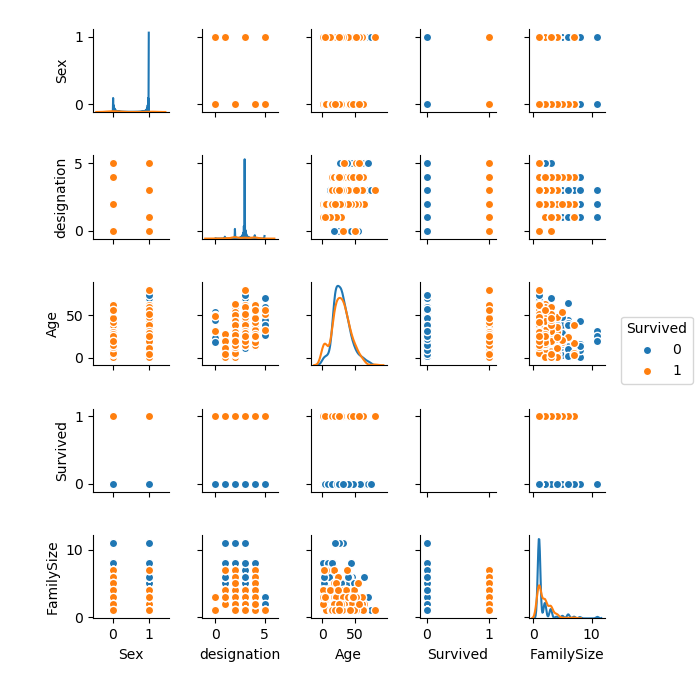

In [8]:
g = sns.pairplot(train[['Sex','designation','Age','Survived','FamilySize']], hue='Survived', diag_kind='kde', size=1)
g.fig.set_size_inches(7,7)
plt.show()

<IPython.core.display.Javascript object>


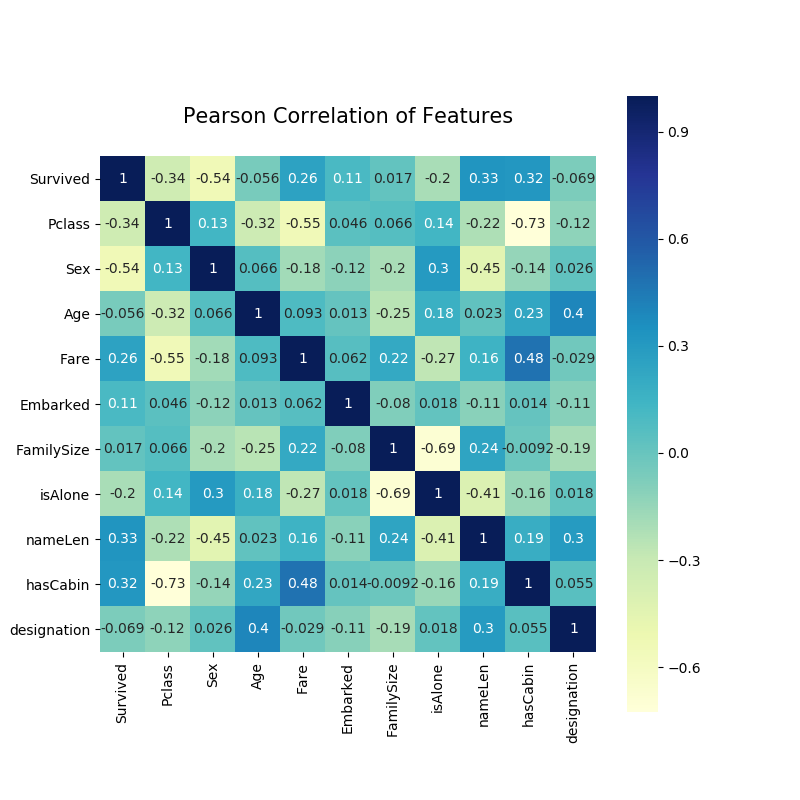

In [9]:
plt.figure(figsize=(8,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
g = sns.heatmap(train.astype(float).corr(),linewidths=0,square=True,annot=True,cmap="YlGnBu")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Don't run all params at once or it won't solve in adequate time
# K-Neighbors

# grid_values = {
#     'weights':['uniform','distance'],
#     'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
#     'leaf_size':range(10,100,10)
# }

# Random Forest

# grid_values = {
#     'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],
#     'max_depth':np.linspace(1, 32, 32),
#     'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True),
#     'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True),
#     'max_features':list(range(1,X_train.shape[1]))
# }

# SVM

# grid_values = {
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma': [0.001, 0.1, 1, 10, 100],
#     'C': [0.1, 1, 10, 100, 1000],
#     'degree': [2, 3, 4, 5, 6]
# }

# clf = KNeighborsClassifier()
# grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,n_jobs=-1,scoring='roc_auc')
# grid_clf_acc.fit(X_train, y_train)
# print('Grid best parameter (max. accuracy): ', grid_clf_acc.best_params_)
# print('Grid best score (accuracy): ', grid_clf_acc.best_score_)
# grid_clf_acc.grid_scores_, grid_clf_acc.best_params_, grid_clf_acc.best_score_

<IPython.core.display.Javascript object>


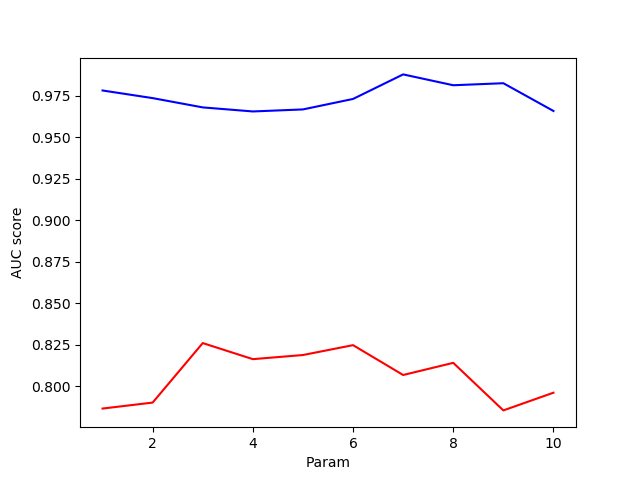

In [12]:
plt.figure()
def aoc_plotter(clf,*args):
    train_results = []
    test_results = []
    feature,list_to_plot = args
    for estimator in list_to_plot:
        param = {feature:estimator}
        model = clf(**param)
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        train_results.append(roc_auc)
        y_pred = model.predict(X_test)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        test_results.append(roc_auc)
    plt.plot(list_to_plot, train_results, 'b', label='Train AUC')
    plt.plot(list_to_plot, test_results, 'r', label='Test AUC')
    plt.ylabel('AUC score')
    plt.xlabel('Param')
    plt.show()
    return None
aoc_plotter(RandomForestClassifier,'max_features',list(range(1,train.shape[1])))
# plt.show()

In [13]:
classifiers = [
    KNeighborsClassifier,
    SVC,
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    GaussianNB,
    ExtraTreesClassifier,
    LogisticRegression,
]

In [14]:
# AdaBoost parameters
ada_params = {
    'n_estimators': 500, 
    'learning_rate': 0.75
}
# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
    'max_features': 4,
    'max_depth': 5,
    'min_samples_leaf': 3,
    'verbose': 0,
    'learning_rate': 0.1,
    'min_samples_split': 30,
    'subsample': 0.8
}
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'warm_start': True,
    #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'verbose': 0
}
# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
# Scalabe Vector Machine Parameters
svm_params = {
    'kernel': 'rbf', 
    'gamma': 1, 
    'C': 1, 
    'degree': 2
}
# K-Neighbors Parameters
kn_params = {
    'algorithm': 'auto',
    'leaf_size': 10,
    'weights': 'distance',
    'n_neighbors': 5,
    'p': 2
}
# Naive-Bayes Parameters
gnb_params = {
    
}
# Logistic Regression Parameters
lr_params = {
    
}

classifier_params = [kn_params, svm_params, rf_params, ada_params, gb_params, gnb_params, et_params, lr_params]

classifier_params

[{'algorithm': 'auto',
  'leaf_size': 10,
  'weights': 'distance',
  'n_neighbors': 5,
  'p': 2},
 {'kernel': 'rbf', 'gamma': 1, 'C': 1, 'degree': 2},
 {'n_jobs': -1,
  'n_estimators': 500,
  'warm_start': True,
  'max_depth': 6,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'verbose': 0},
 {'n_estimators': 500, 'learning_rate': 0.75},
 {'n_estimators': 500,
  'max_features': 4,
  'max_depth': 5,
  'min_samples_leaf': 3,
  'verbose': 0,
  'learning_rate': 0.1,
  'min_samples_split': 30,
  'subsample': 0.8},
 {},
 {'n_jobs': -1,
  'n_estimators': 500,
  'max_depth': 8,
  'min_samples_leaf': 2,
  'verbose': 0},
 {}]

In [29]:
for i,(classifier,params) in enumerate(zip(classifiers,classifier_params)):
    clf = classifier(**params).fit(X_train,y_train)
    y_predict = clf.predict(X_test)
    print(classifier)
    print('Test Scores (accuracy): ',clf.score(X_test,y_test))
    print('Train Scores (accuracy): ',clf.score(X_train,y_train))
    print('ROC-AOC Socres: ',roc_auc_score(y_test,y_predict))
    print('\n')    

<class 'sklearn.neighbors.classification.KNeighborsClassifier'>
Test Scores (accuracy):  0.7359550561797753
Train Scores (accuracy):  0.9985974754558204
ROC-AOC Socres:  0.7095238095238096


<class 'sklearn.svm.classes.SVC'>
Test Scores (accuracy):  0.6573033707865169
Train Scores (accuracy):  0.9929873772791024
ROC-AOC Socres:  0.5158730158730158


<class 'sklearn.ensemble.forest.RandomForestClassifier'>
Test Scores (accuracy):  0.8595505617977528
Train Scores (accuracy):  0.8737727910238429
ROC-AOC Socres:  0.8446514837819186


<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
Test Scores (accuracy):  0.8370786516853933
Train Scores (accuracy):  0.8737727910238429
ROC-AOC Socres:  0.8236714975845411


<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
Test Scores (accuracy):  0.8146067415730337
Train Scores (accuracy):  0.9985974754558204
ROC-AOC Socres:  0.8026915113871635


<class 'sklearn.naive_bayes.GaussianNB'>
Test Scores (accuracy):  0.82022471

In [16]:
# Stacking 
df = X.copy()
df_classifier = np.empty((test.shape[0],5))
df_test = np.empty((test.shape[0],len(classifiers)))

kf = KFold(n_splits=5)
kf.get_n_splits(X) 

for i,classifier in enumerate(classifiers):
    col = str(classifier)
    df[col] = 0

# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y[train_index], y[test_index]
#     for i,(classifier,params) in enumerate(zip(classifiers,classifier_params)):
#         clf = classifier(**params).fit(X_train,y_train)
#         y_predict = clf.predict(X_test)
#         col = df.columns.get_loc(str(classifier))
#         df.iloc[test_index,col] = y_predict
#         df_classifier[:,i] = clf.predict(train)
#     print(df_classifier)    
# df.head()

for j,(classifier,params) in enumerate(zip(classifiers,classifier_params)):
    for i,(train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = classifier(**params).fit(X_train,y_train)
        y_predict = clf.predict(X_test)
        col = df.columns.get_loc(str(classifier))
        df.iloc[test_index,col] = y_predict
        df_classifier[:,i] = clf.predict(test)
    df_test[:,j] = df_classifier.mean(axis=1)
df.head()


,Pclass,Sex,Age,Fare,Embarked,FamilySize,isAlone,nameLen,hasCabin,designation,<class 'sklearn.neighbors.classification.KNeighborsClassifier'>,<class 'sklearn.svm.classes.SVC'>,<class 'sklearn.ensemble.forest.RandomForestClassifier'>,<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>,<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>,<class 'sklearn.naive_bayes.GaussianNB'>,<class 'sklearn.ensemble.forest.ExtraTreesClassifier'>,<class 'sklearn.linear_model.logistic.LogisticRegression'>
0,3,1,22.0,7.2500,0,2,0,23,0,3,0,0,0,0,1,0,0,0
1,1,0,38.0,71.2833,1,2,0,51,1,4,1,0,1,1,1,1,1,1
2,3,0,26.0,7.9250,0,1,1,22,0,2,0,0,0,1,1,0,0,1
3,1,0,35.0,53.1000,0,2,0,44,1,4,1,0,1,1,1,1,1,1
4,3,1,35.0,8.0500,0,1,1,24,0,3,0,0,0,0,0,0,0,0


In [17]:
index = list(range(0,8,1))
X_2 = df.iloc[:,10:18]
X_2.columns = index
print(X_2.shape)
X_2.head()

(891, 8)


,0,1,2,3,4,5,6,7
0,0,0,0,0,1,0,0,0
1,1,0,1,1,1,1,1,1
2,0,0,0,1,1,0,0,1
3,1,0,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0


In [18]:
df_t = pd.DataFrame(df_test,columns=index)
print(df_t.shape)
df_t.head()

(418, 8)


,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0
1,0.0,0.0,0.2,0.2,0.0,1.0,0.2,0.0
2,0.0,0.0,0.0,0.4,0.2,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0
4,0.4,0.0,0.8,0.6,0.0,1.0,0.6,1.0


<IPython.core.display.Javascript object>


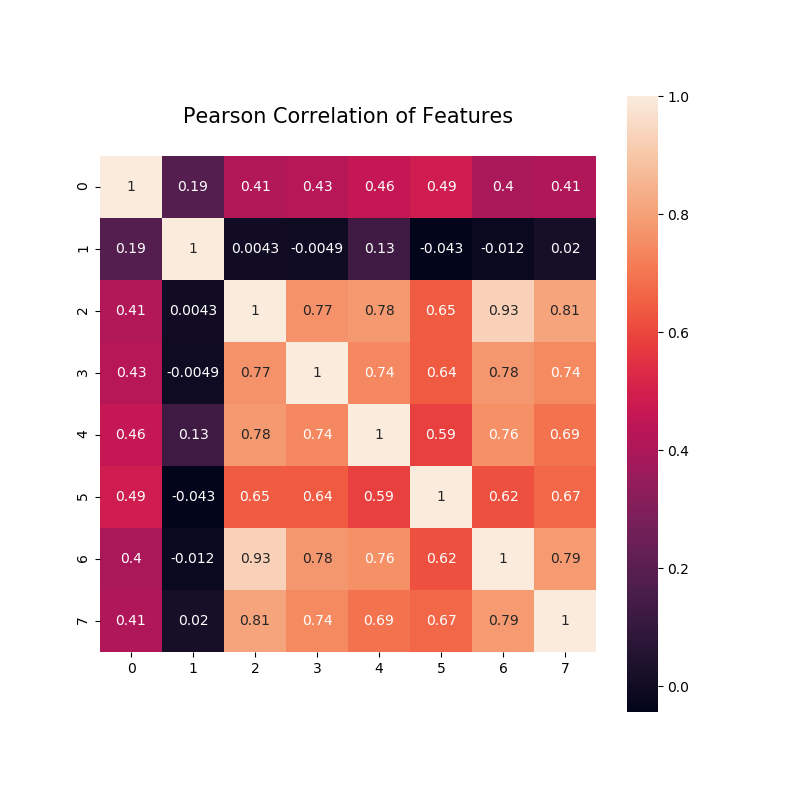

In [19]:
plt.figure(figsize=(8,8))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
g = sns.heatmap(X_2.astype(float).corr(),linewidths=0,square=True,annot=True)
plt.show()

In [20]:
# 0.76076 Score
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(X_2, y)
predictions = gbm.predict(df_t)

In [28]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y,random_state=0)
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
    n_estimators=2000,
    max_depth=4,
    min_child_weight=2,
    gamma=0.9,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=1).fit(X_2_train, y_2_train)
y_pred = gbm.predict(X_2_test)
print(gbm.score(X_2_train,y_2_train))
print(gbm.score(X_2_test,y_2_test))

0.8517964071856288
0.8161434977578476


In [30]:
# 0.7655 Score
clf = ExtraTreesClassifier(**et_params).fit(X,y)
predictions = clf.predict(test)

In [32]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /home/kartikey/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt5jp8g97
  JVM stdout: /tmp/tmpt5jp8g97/h2o_kartikey_started_from_python.out
  JVM stderr: /tmp/tmpt5jp8g97/h2o_kartikey_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,04 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,26 days
H2O cluster name:,H2O_from_python_kartikey_0kj8xa
H2O cluster total nodes:,1
H2O cluster free memory:,2.906 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [34]:
htrain = h2o.H2OFrame(train)
htest = h2o.H2OFrame(test)
x =htrain.columns
y ='Survived'
x.remove(y)
# This line is added in the case of classification
htrain[y] = htrain[y].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [37]:
aml = H2OAutoML(max_runtime_secs = 1200)
aml.train(x=x, y =y, training_frame=htrain)
lb = aml.leaderboard
print (lb)
print('Generate predictions…')
test_y = aml.leader.predict(htest)
test_y = test_y.as_data_frame()

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GBM_grid_1_AutoML_20181218_192603_model_5,0.880178,0.479658,0.179994,0.387911,0.150475
GBM_grid_1_AutoML_20181218_192603_model_7,0.875305,0.499259,0.186426,0.398864,0.159093
GBM_grid_1_AutoML_20181218_192007_model_5,0.875204,0.505776,0.184489,0.402952,0.162371
GBM_grid_1_AutoML_20181218_192007_model_10,0.875016,0.418744,0.182703,0.359942,0.129558
GBM_grid_1_AutoML_20181218_192603_model_9,0.87436,0.419926,0.180148,0.361944,0.131003
StackedEnsemble_AllModels_AutoML_20181218_192007,0.873775,0.409616,0.177978,0.356134,0.126832
XGBoost_grid_1_AutoML_20181218_192603_model_17,0.873614,0.41253,0.178444,0.356594,0.127159
GBM_grid_1_AutoML_20181218_192007_model_24,0.871611,0.523642,0.185031,0.412055,0.169789
StackedEnsemble_BestOfFamily_AutoML_20181218_192007,0.871477,0.409107,0.171384,0.355297,0.126236
XGBoost_grid_1_AutoML_20181218_192603_model_5,0.871332,0.41372,0.172937,0.356888,0.127369



Generate predictions…
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [41]:
print(predictions.shape)
print(test_y.shape)
pred = test_y['predict']

(418,)
(418, 3)


In [42]:
df = pd.read_csv('test.csv', header=0, dtype={'Age': np.float64})
StackingSubmission = pd.DataFrame({ 'PassengerId': df['PassengerId'],
                            'Survived': pred })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)